# LSTM for Time Series Prediction
> 연습용, LSTM을 사용하여 시계열 예측 신경망 구축

- lookback이 의미하는바를 정확히 모르겠음.

Let’s see how LSTM can be used to build a time series prediction neural network with an example.

The problem you will look at in this post is the international airline passengers prediction problem. This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

It is a regression problem. That is, given the number of passengers (in unit of 1,000) the recent months, what is the number of passengers the next month. The dataset has only one feature: The number of passengers.

- 국제 항공사 승객 수(1000명 단위)를 예측하는 문제
- 데이터 범위는 1949년 1월부터 1960년 12월까지이며 1달단위로 관측된 데이터이며, 관측치는 $144(12\times 12)$개

## import 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


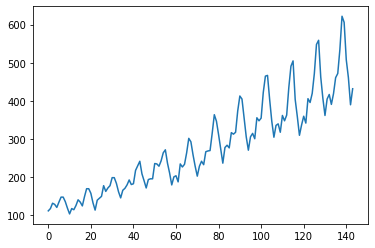

In [12]:
timeseries = df[['Passengers']].values.astype('float32')

plt.plot(timeseries)
plt.show()

This time series has 144 time steps. You can see from the plot that there is an upward trend. There are also some periodicity in the dataset that corresponds to the summer holiday period in the northern hemisphere. Usually a time series should be “detrended” to remove the linear trend component and normalized before processing. For simplicity, these are skipped in this projectc

- 증가하는 추세를 보이지만 여기서는 따로 처리하지 않았음.

## train test split

In [13]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67) # train ratio = 67%
test_size = len(timeseries) - train_size
train_size, test_size

(96, 48)

In [14]:
train, test = timeseries[:train_size], timeseries[train_size:]

In [16]:
train.shape, test.shape

((96, 1), (48, 1))

In [21]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

This function is designed to apply windows on the time series. It is assumed to predict for one time step into the immediate future. It is designed to convert a time series into a tensor of dimensions (window sample, time steps, features). A time series of 
 time steps can produce roughly 
 windows (because a window can start from any time step as long as the window does not go beyond the boundary of the time series). Within one window, there are multiple consecutive time steps of values. In each time step, there can be multiple features. In this dataset, there is only one.

## lookback=1

In [76]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


In [90]:
X_train[:5]

tensor([[[112.]],

        [[118.]],

        [[132.]],

        [[129.]],

        [[121.]]])

In [89]:
y_train[:5]

tensor([[[118.]],

        [[132.]],

        [[129.]],

        [[121.]],

        [[135.]]])

Now you can build the LSTM model to predict the time series. With lookback=1, it is quite surely that the accuracy would not be good for too little clues to predict. But this is a good example to demonstrate the structure of the LSTM model.

## Model

The model is created as a class, in which a LSTM layer and a fully-connected layer is used.

In [43]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

The output of nn.LSTM() is a tuple. The first element is the generated hidden states, one for each time step of the input. The second element is the LSTM cell’s memory and hidden states, which is not used here.

## Training and Verifying Your LSTM Network

Because it is a regression problem, MSE is chosen as the loss function, which is to be minimized by Adam optimizer. In the code below, the PyTorch tensors are combined into a dataset using `torch.utils.data.TensorDataset()` and batch for training is provided by a `DataLoader`. The model performance is evaluated once per 100 epochs, on both the trainning set and the test set:

In [57]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.9365, test RMSE 422.3676
Epoch 100: train RMSE 184.9790, test RMSE 379.4668
Epoch 200: train RMSE 152.4027, test RMSE 344.3236
Epoch 300: train RMSE 124.2188, test RMSE 312.2975
Epoch 400: train RMSE 101.0204, test RMSE 283.2189
Epoch 500: train RMSE 82.6843, test RMSE 257.0794
Epoch 600: train RMSE 66.4356, test RMSE 231.9688
Epoch 700: train RMSE 54.0870, test RMSE 208.9810
Epoch 800: train RMSE 44.0830, test RMSE 188.2280
Epoch 900: train RMSE 37.0532, test RMSE 169.9665
Epoch 1000: train RMSE 32.5043, test RMSE 154.2343
Epoch 1100: train RMSE 28.9322, test RMSE 141.3780
Epoch 1200: train RMSE 27.4202, test RMSE 131.0028
Epoch 1300: train RMSE 25.8251, test RMSE 122.6009
Epoch 1400: train RMSE 25.7696, test RMSE 116.9653
Epoch 1500: train RMSE 24.2167, test RMSE 111.3310
Epoch 1600: train RMSE 24.6531, test RMSE 106.7048
Epoch 1700: train RMSE 24.3270, test RMSE 103.3886
Epoch 1800: train RMSE 23.5308, test RMSE 101.1581
Epoch 1900: train RMSE 23.3630, test R

As the dataset is small, the model should be trained for long enough to learn about the pattern. Over these 2000 epochs trained, you should see the RMSE on both training set and test set decreasing:

It is expected to see the RMSE of test set is an order of magnitude larger. The RMSE of 100 means the prediction and the actual target would be in average off by 100 in value (i.e., 100,000 passengers in this dataset).

In [65]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

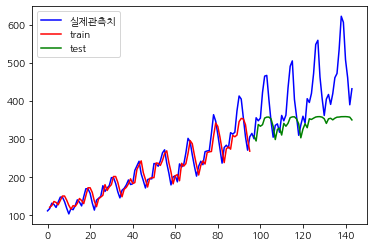

In [67]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b', label = '실제관측치')
plt.plot(train_plot, c='r', label = 'train')
plt.plot(test_plot, c='g', label = 'test')
plt.legend()
plt.show()

The training set is plotted in red while the test set is plotted in green. The blue curve is what the actual data looks like. You can see that the model can fit well to the training set but not very well on the test set.

- training set 에 대해서는 잘 맞추는 것 같은데 test set에 대해서는 잘 맞추지 못한다.

Tying together, below is the complete code, except the parameter lookback is set to 4 this time:

## lookback=4

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
 
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
## 이번에는 lookback을 4로 놓을 것.    
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8) # shuffle: 샘플을 섞을지 시간 순서대로 추출할지 결정
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

Epoch 0: train RMSE 225.5574, test RMSE 424.7804
Epoch 100: train RMSE 177.5963, test RMSE 374.4650
Epoch 200: train RMSE 138.9036, test RMSE 332.0411
Epoch 300: train RMSE 108.2241, test RMSE 295.1660
Epoch 400: train RMSE 86.0366, test RMSE 263.5869
Epoch 500: train RMSE 65.9311, test RMSE 232.4372
Epoch 600: train RMSE 51.7861, test RMSE 204.3946
Epoch 700: train RMSE 41.5776, test RMSE 180.0017
Epoch 800: train RMSE 34.7810, test RMSE 159.1152
Epoch 900: train RMSE 29.9309, test RMSE 141.1872
Epoch 1000: train RMSE 26.6003, test RMSE 126.3749
Epoch 1100: train RMSE 24.6251, test RMSE 114.9184
Epoch 1200: train RMSE 23.2474, test RMSE 105.3578
Epoch 1300: train RMSE 22.2368, test RMSE 98.2287
Epoch 1400: train RMSE 21.5524, test RMSE 92.6251
Epoch 1500: train RMSE 21.1995, test RMSE 87.6587
Epoch 1600: train RMSE 20.5447, test RMSE 84.6245
Epoch 1700: train RMSE 20.1870, test RMSE 81.5615
Epoch 1800: train RMSE 20.0715, test RMSE 79.2392
Epoch 1900: train RMSE 19.9252, test RMSE 78.

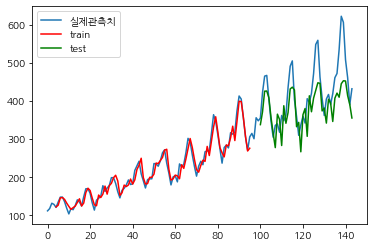

In [71]:
# plot
plt.plot(timeseries, label='실제관측치')
plt.plot(train_plot, c='r', label='train')
plt.plot(test_plot, c='g', label='test')
plt.legend()
plt.show()

- 이전보다(lookback=1) 테스트 데이터에 대해 훨씬 잘 맞춘다.

Running the above code will produce the plot below. From both the RMSE measure printed and the plot, you can notice that the model can now do better on the test set.

This is also why the `create_dataset()` function is designed in such way: When the model is given a time series of time $t$ to $t+3$(as lookback=4), its output is the prediction of $t+1$ to $t+4$. 
However, $t+1$ to $t+3$ are also known from the input. By using these in the loss function, the model effectively was provided with more clues to train. This design is not always suitable but you can see it is helpful in this particular example

## lookback?

`-` lookback 살펴보기

- lookback: 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
- delay : 타깃으로 사용할 미래의 타임스텝 
- shuffle: 샘플을 섞을지 시간 순서대로 추출할지 결정

In [91]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [96]:
X_train.shape, y_train.shape

(torch.Size([92, 4, 1]), torch.Size([92, 4, 1]))

In [103]:
df[:10]

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [106]:
X_train.T

tensor([[[112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
          118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
          114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
          162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
          209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
          272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
          302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
          315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
          318., 374., 413., 405.],
         [118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
          115., 126., 141., 135., 125., 149., 170., 170., 158., 133., 114.,
          140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
          146., 166., 171., 180., 193., 181., 183., 218., 230., 242., 209.,
          191., 172., 194., 196., 196., 236., 235., 2

In [100]:
y_train.T

tensor([[[118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
          115., 126., 141., 135., 125., 149., 170., 170., 158., 133., 114.,
          140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
          146., 166., 171., 180., 193., 181., 183., 218., 230., 242., 209.,
          191., 172., 194., 196., 196., 236., 235., 229., 243., 264., 272.,
          237., 211., 180., 201., 204., 188., 235., 227., 234., 264., 302.,
          293., 259., 229., 203., 229., 242., 233., 267., 269., 270., 315.,
          364., 347., 312., 274., 237., 278., 284., 277., 317., 313., 318.,
          374., 413., 405., 355.],
         [132., 129., 121., 135., 148., 148., 136., 119., 104., 118., 115.,
          126., 141., 135., 125., 149., 170., 170., 158., 133., 114., 140.,
          145., 150., 178., 163., 172., 178., 199., 199., 184., 162., 146.,
          166., 171., 180., 193., 181., 183., 218., 230., 242., 209., 191.,
          172., 194., 196., 196., 236., 235., 229., 2

- <https://miruetoto.github.io/yechan3/posts/3_Researches/ITSTGCN/2022-12-29-STGCN-tutorial.html#pytorch-geometric-temporal-%EC%9D%98-%EC%9E%90%EB%A3%8C%ED%98%95> 

lag=4라고 생각하면 될 것같은데 각각 한달 후의 데이터를 예측하는 것이라 $y$의 차원이 전에 했던거랑 다름.